# Class imbalance

This notebook is pracitce of class imbalance handling approaches like SMOTE, ADASYN, Tomek Links, SMOTETomek

## Basic Learing Examples

### Prepara data

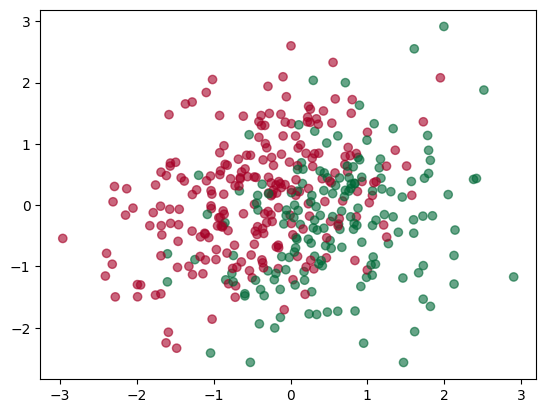

In [1]:
# Generate 2 features binary data 400 points total, add some noise
import numpy as np
import matplotlib.pyplot as plt
from mlpeople.models.logistic import generate_logistic_regression_data

X_raw, y_raw, true_theta = generate_logistic_regression_data(
    n=400,
    p=2,
    intercept=-0.5,
    coefs=[2, -1],
    seed=42,
    sigma=2,
)

plt.scatter(X_raw[:, 0], X_raw[:, 1], c=y_raw, alpha=0.6, cmap="RdYlGn");

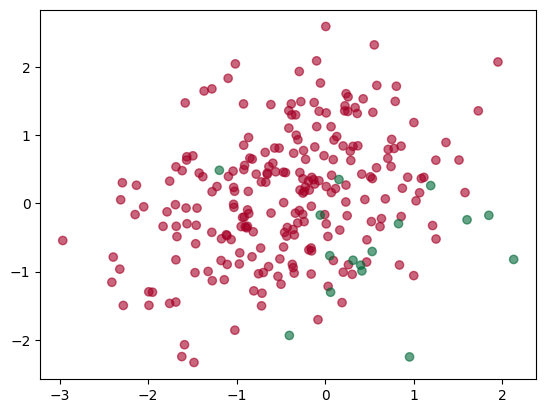

In [2]:
# Randomly remove 90% of data where target=1 to create disbalance
import numpy as np

# Find indices where y == 1
pos_idx = np.where(y_raw == 1)[0]

# Randomly choose 10% to KEEP
np.random.seed(42)  # optional for reproducibility
keep_pos = np.random.choice(pos_idx, size=int(0.1 * len(pos_idx)), replace=False)

# Keep all y == 0 plus the sampled positives
neg_idx = np.where(y_raw == 0)[0]
final_idx = np.concatenate([neg_idx, keep_pos])

# Subset the data
X_reduced = X_raw[final_idx]
y_reduced = y_raw[final_idx]

# Plot to verify
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_reduced, alpha=0.6, cmap="RdYlGn")
plt.show()


### Base logistic regression

f1 score: 0.3


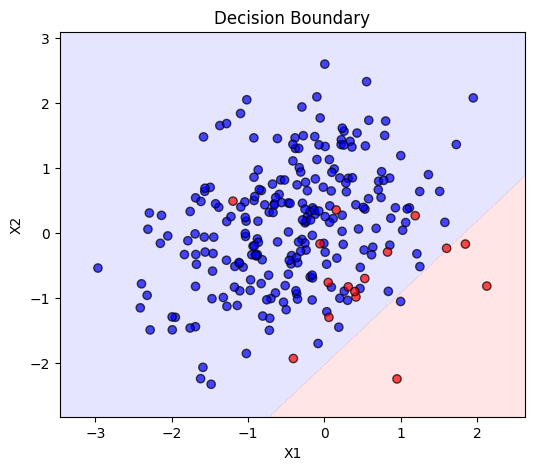

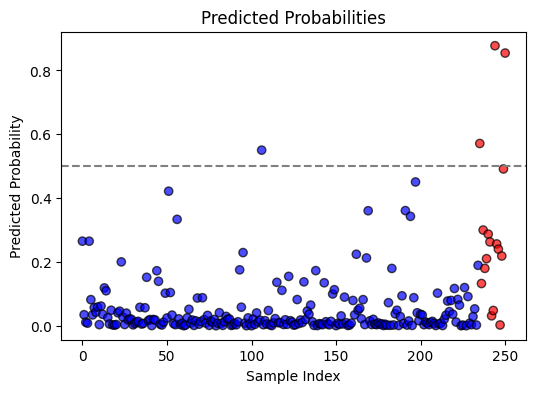

In [3]:
from mlpeople.models.logistic import (
    fit_logistic,
    predict,
    plot_decision_boundary_2d,
    plot_predicted_probabilities,
    f1_score
)
from mlpeople.math import add_bias_column

def show_fit_result(X, y):
    # Fit model
    theta, _ = fit_logistic(X, y, lr=0.2, epochs=1000, verbose=False)

    y_pred = predict(theta, add_bias_column(X))

    print(f"f1 score: {round(f1_score(y, y_pred), 2)}")

    plot_decision_boundary_2d(X, y, theta)
    plot_predicted_probabilities(X, y, theta)


show_fit_result(X_reduced, y_reduced)


### Strategy 1. Random oversampling

Random oversampling duplicates existing examples from the minority class with return. Each data point in the minority has the same probability of being duplicated.

f1 score: 0.83


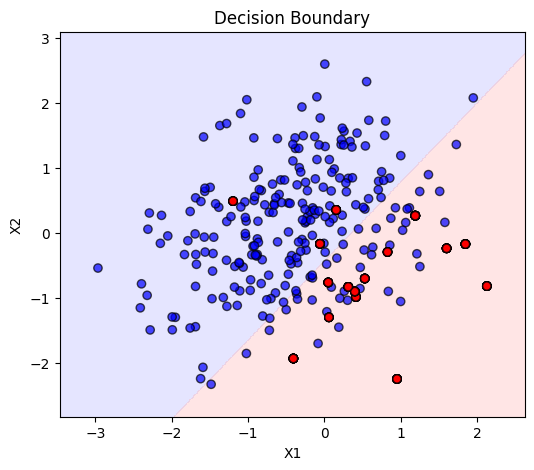

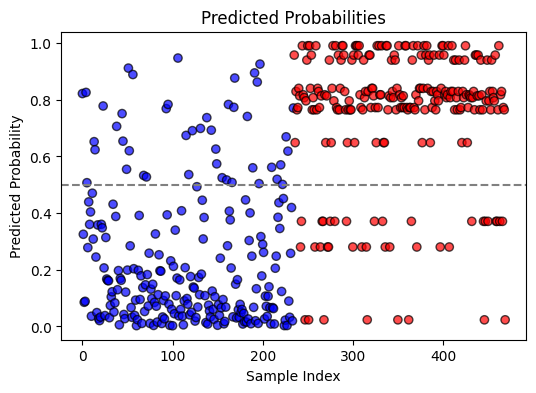

In [4]:
from imblearn.over_sampling import RandomOverSampler

# Perform random oversampling
ros = RandomOverSampler(random_state=0)
X_train_ros, y_train_ros = ros.fit_resample(X_reduced, y_reduced)

show_fit_result(X_train_ros, y_train_ros)

### Strategy 2. Random undersampling

Random undersampling removes existing samples from a major class. Each data point in the major class has an equal chance of being removed.

f1 score: 0.76


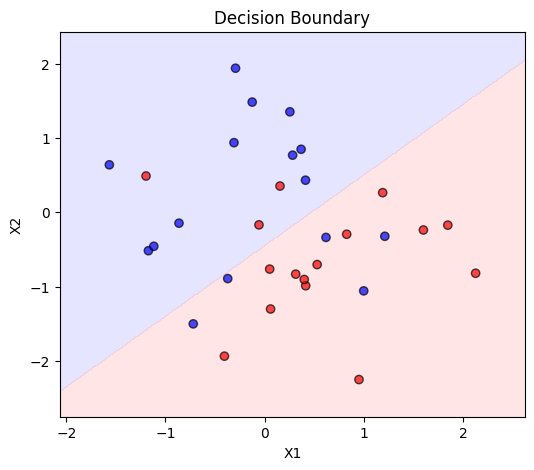

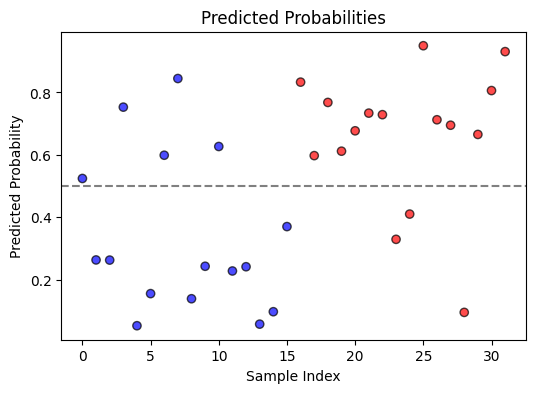

In [5]:
from imblearn.under_sampling import RandomUnderSampler

# Perform random sampling
rus = RandomUnderSampler(random_state=0)
X_train_rus, y_train_rus = rus.fit_resample(X_reduced, y_reduced)

show_fit_result(X_train_rus, y_train_rus)

### Strategy 3. Oversampling with SMOTE

SMOTE (Synthetic Minority Oversampling Technique) is an oversampling method. Intuitively, SMOTE creates synthetic data points by interpolating between data points of a minor class that are close to each other.

https://imbalanced-learn.org/stable/over_sampling.html#smote-adasyn

https://youtu.be/NvrfSntsm7w

f1 score: 0.84


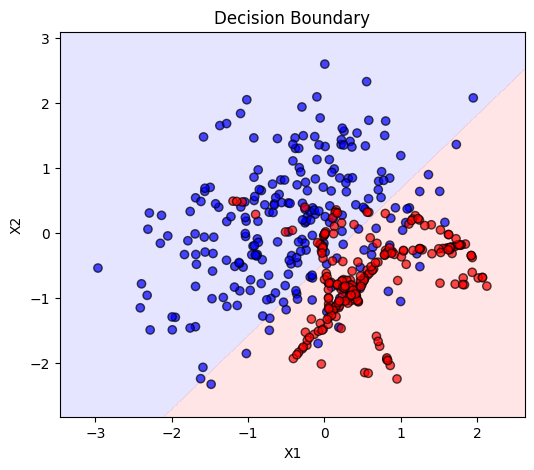

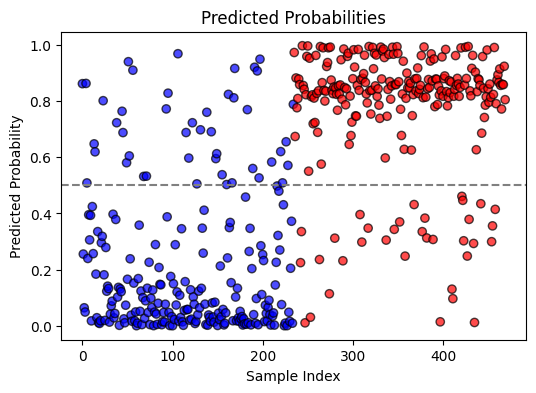

In [6]:
from imblearn.over_sampling import SMOTE

# Perform SMOTE sampling
smote = SMOTE(random_state=0)
X_train_smote, y_train_smote = smote.fit_resample(X_reduced, y_reduced)

show_fit_result(X_train_smote, y_train_smote)

### Strategy 4. Oversampling with ADASYN

https://imbalanced-learn.org/stable/over_sampling.html#smote-adasyn

https://youtu.be/69CoxAoR3Gs

f1 score: 0.83


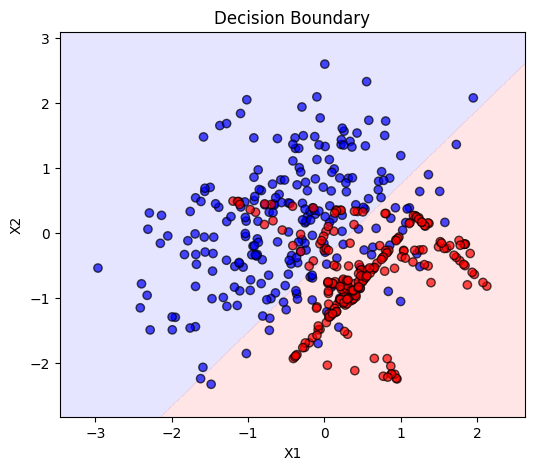

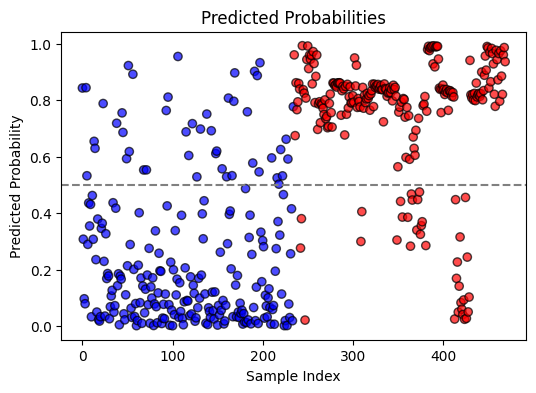

In [7]:
from imblearn.over_sampling import ADASYN

# Perform ADASYN sampling
adasyn = ADASYN(random_state=0)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_reduced, y_reduced)

show_fit_result(X_train_adasyn, y_train_adasyn)

### Strategy 5. Undersampling using links (Tomek Links)

A Tomek link is a pair of points that are very close to each other but belong to different classes.

https://youtu.be/IIj6J0TW-nw

samples before undersampling: 251
samples after undersampling: 244
f1 score: 0.38


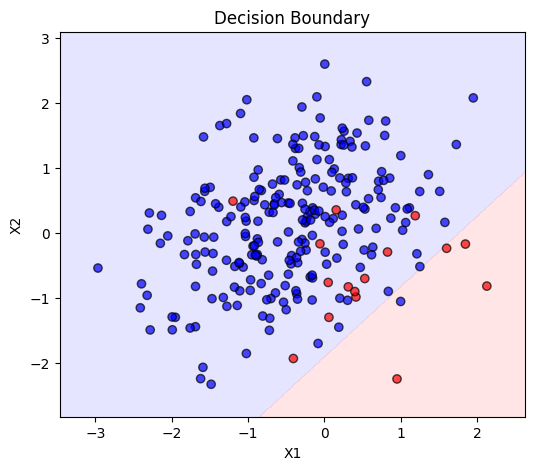

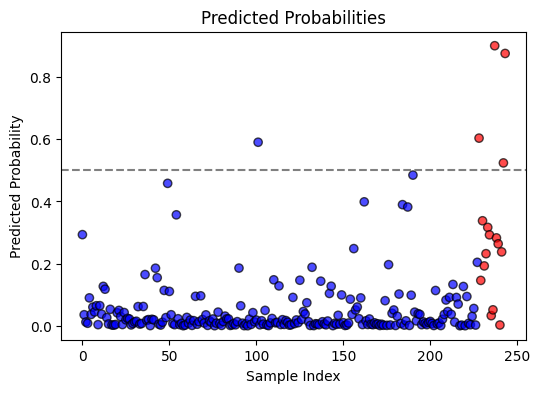

In [8]:
from imblearn.under_sampling import TomekLinks

# Perform Tomek Link undersampling
tomek = TomekLinks()
X_train_tomek, y_train_tomek = tomek.fit_resample(X_reduced, y_reduced)

print(f"samples before undersampling: {len(y_reduced)}")
print(f"samples after undersampling: {len(y_train_tomek)}")

show_fit_result(X_train_tomek, y_train_tomek)

### Strategy 6. SMOTEK: Oversample with SMOTE, then Undersample with Tomek Links

samples before re-sampling: 251
samples after re-sampling: 436
f1 score: 0.86


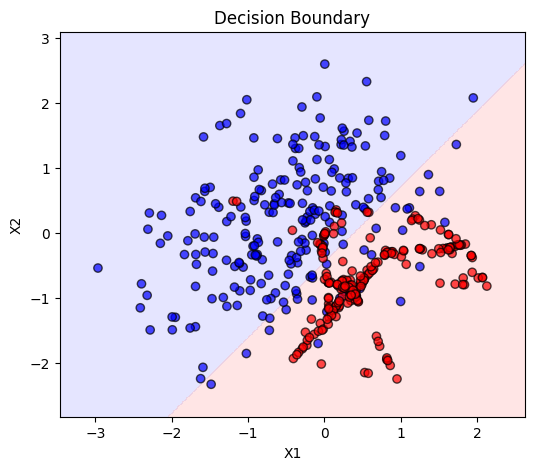

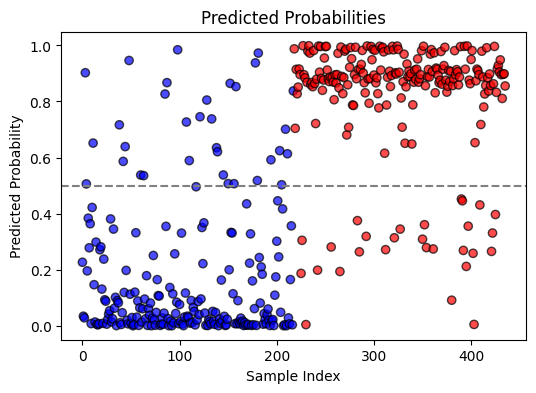

In [9]:
from imblearn.combine import SMOTETomek

smotetomek = SMOTETomek(random_state=0)
X_train_smotetomek, y_train_smotetomek = smotetomek.fit_resample(X_reduced, y_reduced)

print(f"samples before re-sampling: {len(y_reduced)}")
print(f"samples after re-sampling: {len(X_train_smotetomek)}")

show_fit_result(X_train_smotetomek, y_train_smotetomek)

## Bank Customers dataset Experiments

In [10]:
import importlib
import mlpeople.optimization.experiments.polynomial_pipeline_experiments as ml_vis_kde
importlib.reload(ml_vis_kde)

<module 'mlpeople.optimization.experiments.polynomial_pipeline_experiments' from '/Users/maksymstefanko/ML/ML-love/data-loves-ml-for-people-course/src/mlpeople/optimization/experiments/polynomial_pipeline_experiments.py'>

In [11]:
import pandas as pd
from sklearn.linear_model import LogisticRegression

from mlpeople.optimization.experiments.polynomial_pipeline_experiments import run_experiment_poly

In [12]:
raw_df = pd.read_csv('downloads/train.csv', index_col=0)
target_col = 'Exited'

In [13]:
# result without re-sampling
fixed_params = {
    "stratify_col": target_col,
    "drop_cols": ["Surname", "CustomerId", "Tenure", "EstimatedSalary", "HasCrCard", "CreditScore"],
    "scale_mode": "standard",
    "encode_drop": None,
    "separate_binary_numeric": False,
    "polynomial_degree": 4,
    "polynomial_after_scale": True,
    "top_n_cat_values": None,
    "binary_cat_flag_cols": {
        'Geography': [{'flag_name': 'IsGermany',
            'value': 'Germany',
            'drop_original': True
        }]
    },
    "binary_num_flag_cols": None,
    "polynomial_interaction_only": False,
    "model": LogisticRegression(C=0.5, solver='liblinear')
}

result = run_experiment_poly(
    raw_df,
    target_col,
    **fixed_params
)
roc_auc_train = result["roc_auc_train"]
roc_auc_val = result["roc_auc_val"]
roc_auc_train, roc_auc_val

(0.9373648601520542, 0.9386991563207353)

### Random Oversampling

In [14]:
result_ros = run_experiment_poly(
    raw_df,
    target_col,
    sampler="randomover",
    **fixed_params
)
roc_auc_train_ros = result_ros["roc_auc_train"]
roc_auc_val_ros = result_ros["roc_auc_val"]
roc_auc_train_ros, roc_auc_val_ros

(0.9372408489640128, 0.9376157486796077)

### Random Undersampling

In [15]:
result_rus = run_experiment_poly(
    raw_df,
    target_col,
    sampler="randomunder",
    **fixed_params
)
roc_auc_train_rus = result_rus["roc_auc_train"]
roc_auc_val_rus = result_rus["roc_auc_val"]
roc_auc_train_rus, roc_auc_val_rus

(0.9360976710317577, 0.9369061664037313)

### Run Experiments

In [16]:
from mlpeople.optimization.experiments.polynomial_pipeline_experiments import run_experiments_poly

fixed_params_options = {
    "test_size_options": [0.2],
    "stratify_col_options": [fixed_params["stratify_col"]],
    "drop_cols_options": [fixed_params["drop_cols"]],
    "scale_mode_options": [fixed_params["scale_mode"]],
    "encode_drop_options": [fixed_params["encode_drop"]],
    "model_options": [fixed_params["model"]],
    "separate_binary_numeric_options": [fixed_params["separate_binary_numeric"]],
    "polynomial_degree_options": [fixed_params["polynomial_degree"]],
    "polynomial_after_scale_options": [fixed_params["polynomial_after_scale"]],
    "top_n_cat_values_options": [fixed_params["top_n_cat_values"]],
    "binary_cat_flag_cols_options": [fixed_params["binary_cat_flag_cols"]],
    "binary_num_flag_cols_options": [fixed_params["binary_num_flag_cols"]],
    "polynomial_interaction_only_options": [fixed_params["polynomial_interaction_only"]],
}

#### Samplers & Stratify by target

In [17]:
%%time

# compare results for different re-sampling strategies and no re-sampling
sampler_options = [None, "smote", "adasin", "smotetomek", "randomover", "randomunder", "tomeklinks"]
# compare results for stratify byt target true/false
stratify_col_options = [target_col, None]

results_sampler = run_experiments_poly(
    raw_df,
    target_col,
    test_size_options=fixed_params_options["test_size_options"],
    stratify_col_options=stratify_col_options,
    drop_cols_options=fixed_params_options["drop_cols_options"],
    scale_mode_options=fixed_params_options["scale_mode_options"],
    encode_drop_options=fixed_params_options["encode_drop_options"],
    model_options=fixed_params_options["model_options"],
    separate_binary_numeric_options=fixed_params_options["separate_binary_numeric_options"],
    polynomial_degree_options=fixed_params_options["polynomial_degree_options"],
    polynomial_after_scale_options=fixed_params_options["polynomial_after_scale_options"],
    top_n_cat_values_options=fixed_params_options["top_n_cat_values_options"],
    binary_cat_flag_cols_options=fixed_params_options["binary_cat_flag_cols_options"],
    binary_num_flag_cols_options=fixed_params_options["binary_num_flag_cols_options"],
    polynomial_interaction_only_options=fixed_params_options["polynomial_interaction_only_options"],
    sampler_options=sampler_options
)

results_sampler[["sampler","stratify_col","roc_auc_train", "roc_auc_val"]].sort_values("roc_auc_val", ascending=False).head(20)

CPU times: user 30 s, sys: 3.75 s, total: 33.8 s
Wall time: 18.6 s


,sampler,stratify_col,roc_auc_train,roc_auc_val
0,None,Exited,0.937365,0.938699
6,tomeklinks,Exited,0.936988,0.938359
4,randomover,Exited,0.937241,0.937616
1,smote,Exited,0.937139,0.937568
5,randomunder,Exited,0.936098,0.936906
3,smotetomek,Exited,0.936899,0.936865
2,adasin,Exited,0.936822,0.935796
7,None,None,0.940424,0.923730
11,randomover,None,0.940350,0.923709
13,tomeklinks,None,0.939933,0.923560


In [18]:
fixed_params_options["sampler_options"] = [None]

####  SVC model vs LogisticRegression

In [53]:
%%time
from sklearn.svm import SVC

# compare different SVC model results with LogisticRegression
model_options = [
    LogisticRegression(C=0.5, solver='liblinear'), # base model
    SVC(kernel='linear', probability=True),
    SVC(kernel='linear', probability=True, C=0.5),
    SVC(kernel='linear', probability=True, C=2),
    SVC(kernel='poly', probability=True),
    SVC(kernel='sigmoid', probability=True),
    SVC(kernel='rbf', probability=True),
    SVC(kernel='precomputed', probability=True),
]

results_svc_model = run_experiments_poly(
    raw_df,
    target_col,
    test_size_options=fixed_params_options["test_size_options"],
    stratify_col_options=fixed_params_options["stratify_col_options"],
    drop_cols_options=fixed_params_options["drop_cols_options"],
    scale_mode_options=fixed_params_options["scale_mode_options"],
    encode_drop_options=fixed_params_options["encode_drop_options"],
    model_options=model_options,
    separate_binary_numeric_options=fixed_params_options["separate_binary_numeric_options"],
    polynomial_degree_options=fixed_params_options["polynomial_degree_options"],
    polynomial_after_scale_options=fixed_params_options["polynomial_after_scale_options"],
    top_n_cat_values_options=fixed_params_options["top_n_cat_values_options"],
    binary_cat_flag_cols_options=fixed_params_options["binary_cat_flag_cols_options"],
    binary_num_flag_cols_options=fixed_params_options["binary_num_flag_cols_options"],
    polynomial_interaction_only_options=fixed_params_options["polynomial_interaction_only_options"],
    sampler_options=fixed_params_options["sampler_options"],
)

results_svc_model[["model","roc_auc_train", "roc_auc_val"]].sort_values("roc_auc_val", ascending=False).head(20)

FAILED: Precomputed matrix must be a square matrix. Input is a 12000x127 matrix.
CPU times: user 4min 51s, sys: 2.17 s, total: 4min 53s
Wall time: 4min 54s


,model,roc_auc_train,roc_auc_val
0,"LogisticRegression(C=0.5, solver='liblinear')",0.937365,0.938699
3,"SVC(C=2, kernel='linear', probability=True)",0.911226,0.915233
2,"SVC(C=0.5, kernel='linear', probability=True)",0.911103,0.914794
1,"SVC(kernel='linear', probability=True)",0.910982,0.914726
6,SVC(probability=True),0.899734,0.898600
4,"SVC(kernel='poly', probability=True)",0.880438,0.865364
5,"SVC(kernel='sigmoid', probability=True)",0.800945,0.800292


#### SVC model regularization

In [19]:
%%time
from sklearn.svm import SVC

model_options = [
    SVC(kernel='linear', probability=True),
    SVC(kernel='linear', probability=True, C=0.5),
    SVC(kernel='linear', probability=True, C=0.2, max_iter=2000),
    SVC(kernel='linear', probability=True, C=2),
    SVC(kernel='linear', probability=True, C=5, max_iter=2000),
]

results_svc_model_2 = run_experiments_poly(
    raw_df,
    target_col,
    test_size_options=fixed_params_options["test_size_options"],
    stratify_col_options=fixed_params_options["stratify_col_options"],
    drop_cols_options=fixed_params_options["drop_cols_options"],
    scale_mode_options=fixed_params_options["scale_mode_options"],
    encode_drop_options=fixed_params_options["encode_drop_options"],
    model_options=model_options,
    separate_binary_numeric_options=fixed_params_options["separate_binary_numeric_options"],
    polynomial_degree_options=fixed_params_options["polynomial_degree_options"],
    polynomial_after_scale_options=fixed_params_options["polynomial_after_scale_options"],
    top_n_cat_values_options=fixed_params_options["top_n_cat_values_options"],
    binary_cat_flag_cols_options=fixed_params_options["binary_cat_flag_cols_options"],
    binary_num_flag_cols_options=fixed_params_options["binary_num_flag_cols_options"],
    polynomial_interaction_only_options=fixed_params_options["polynomial_interaction_only_options"],
    sampler_options=fixed_params_options["sampler_options"],
)

results_svc_model_2[["model", "roc_auc_train", "roc_auc_val"]].sort_values("roc_auc_val", ascending=False).head(10)

/opt/miniconda3/envs/mlpeople4/lib/python3.12/site-packages/sklearn/svm/_base.py:313: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/miniconda3/envs/mlpeople4/lib/python3.12/site-packages/sklearn/svm/_base.py:313: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


CPU times: user 3min 47s, sys: 2.6 s, total: 3min 50s
Wall time: 3min 54s


,model,roc_auc_train,roc_auc_val
3,"SVC(C=2, kernel='linear', probability=True)",0.911196,0.915232
1,"SVC(C=0.5, kernel='linear', probability=True)",0.911080,0.914798
0,"SVC(kernel='linear', probability=True)",0.910924,0.914613
2,"SVC(C=0.2, kernel='linear', max_iter=2000, pro...",0.637940,0.661020
4,"SVC(C=5, kernel='linear', max_iter=2000, proba...",0.296146,0.291358


#### Compare more options of LogisticRegression

In [21]:
%%time

model_options = [
    LogisticRegression(C=0.5, solver='liblinear'), # base model
    LogisticRegression(C=0.4, solver='liblinear'),
    LogisticRegression(C=0.3, solver='liblinear'),
    LogisticRegression(C=0.2, solver='liblinear'),
    LogisticRegression(C=0.6, solver='liblinear'),
    LogisticRegression(C=0.7, solver='liblinear'),
    LogisticRegression(solver='liblinear', penalty='l1', C=4),
    LogisticRegression(solver='liblinear', penalty='l1', C=5),
    LogisticRegression(solver='liblinear', penalty='l1', C=6),
    LogisticRegression(solver='liblinear', penalty='l1', C=7),
    LogisticRegression(solver='liblinear', penalty='l1', C=8),
]

results_lg_model = run_experiments_poly(
    raw_df,
    target_col,
    test_size_options=fixed_params_options["test_size_options"],
    stratify_col_options=fixed_params_options["stratify_col_options"],
    drop_cols_options=fixed_params_options["drop_cols_options"],
    scale_mode_options=fixed_params_options["scale_mode_options"],
    encode_drop_options=fixed_params_options["encode_drop_options"],
    model_options=model_options,
    separate_binary_numeric_options=fixed_params_options["separate_binary_numeric_options"],
    polynomial_degree_options=fixed_params_options["polynomial_degree_options"],
    polynomial_after_scale_options=fixed_params_options["polynomial_after_scale_options"],
    top_n_cat_values_options=fixed_params_options["top_n_cat_values_options"],
    binary_cat_flag_cols_options=fixed_params_options["binary_cat_flag_cols_options"],
    binary_num_flag_cols_options=fixed_params_options["binary_num_flag_cols_options"],
    polynomial_interaction_only_options=fixed_params_options["polynomial_interaction_only_options"],
    sampler_options=fixed_params_options["sampler_options"],
)

results_lg_model[["model","roc_auc_train", "roc_auc_val"]].sort_values("roc_auc_val", ascending=False).head(20)

/opt/miniconda3/envs/mlpeople4/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/opt/miniconda3/envs/mlpeople4/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(
/opt/miniconda3/envs/mlpeople4/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1

CPU times: user 50.4 s, sys: 460 ms, total: 50.8 s
Wall time: 51.5 s


,model,roc_auc_train,roc_auc_val
2,"LogisticRegression(C=0.3, solver='liblinear')",0.937349,0.938724
4,"LogisticRegression(C=0.6, solver='liblinear')",0.937383,0.938703
0,"LogisticRegression(C=0.5, solver='liblinear')",0.937365,0.938699
1,"LogisticRegression(C=0.4, solver='liblinear')",0.937360,0.938684
3,"LogisticRegression(C=0.2, solver='liblinear')",0.937324,0.938683
10,"LogisticRegression(C=8, penalty='l1', solver='...",0.937378,0.938669
8,"LogisticRegression(C=6, penalty='l1', solver='...",0.937374,0.938664
9,"LogisticRegression(C=7, penalty='l1', solver='...",0.937401,0.938661
7,"LogisticRegression(C=5, penalty='l1', solver='...",0.937377,0.938660
6,"LogisticRegression(C=4, penalty='l1', solver='...",0.937364,0.938660


#### Update test data prediction

In [22]:
train_pred_proba, val_pred_proba, roc_auc_train, roc_auc_val, poly_model_pipeline_optimal_v2 = run_experiment_poly(
    raw_df,
    target_col,
    stratify_col=target_col,
    drop_cols=["Surname", "CustomerId", "Tenure", "EstimatedSalary", "HasCrCard", "CreditScore"],
    scale_mode="standard",
    encode_drop=None,
    separate_binary_numeric=False,
    polynomial_degree=4,
    polynomial_after_scale=True,
    top_n_cat_values=None,
    binary_cat_flag_cols={
        'Geography': [{'flag_name': 'IsGermany',
            'value': 'Germany',
            'drop_original': True
        }]
    },
    binary_num_flag_cols=None,
    polynomial_interaction_only=False,
    model=LogisticRegression(C=0.3, solver='liblinear')
).values()
roc_auc_train, roc_auc_val

(0.9373488794392748, 0.9387238493723848)

In [23]:
test_raw_df = pd.read_csv("downloads/test.csv")
test_raw_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,15000,15594796.0,Chu,584.0,Germany,Male,30.0,2.0,146053.66,1.0,1.0,1.0,157891.86
1,15001,15642821.0,Mazzi,551.0,France,Male,39.0,5.0,0.00,2.0,1.0,1.0,67431.28
2,15002,15716284.0,Onyekachi,706.0,France,Male,43.0,8.0,0.00,2.0,1.0,0.0,156768.45
3,15003,15785078.0,Martin,717.0,Spain,Male,45.0,3.0,0.00,1.0,1.0,1.0,166909.87
4,15004,15662955.0,Kenechukwu,592.0,Spain,Male,43.0,8.0,0.00,2.0,1.0,1.0,143681.97


In [24]:
test_pred_proba = poly_model_pipeline_optimal_v2.predict_proba(test_raw_df)[:, 1]
test_raw_df["Exited"] = test_pred_proba.round(2)
test_raw_df["Exited"].head()

0    0.08
1    0.01
2    0.06
3    0.47
4    0.02
Name: Exited, dtype: float64

In [25]:
sample_submission_df = pd.read_csv("downloads/sample_submission.csv")
sample_submission_df["Exited"] = test_raw_df["Exited"]
sample_submission_df.to_csv("downloads/submission_poly_reg_optimal_v2.csv", index=False)